In [48]:
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [49]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert images to tensors
])


In [50]:
train_dataset = datasets.ImageFolder(root='Brain_MRI_Images/Train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the validation dataset
val_dataset = datasets.ImageFolder(root='Brain_MRI_Images/Validation', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [51]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)

In [52]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [53]:
device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"
print('Training on', device)
model = CNN(num_classes=3).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics 
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 800 
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)

Training on cpu
Epoch: 1
Training set [0/320 (0%)] Loss: 1.050600
Training set: Average loss: 0.806896
Epoch: 2
Training set [0/320 (0%)] Loss: 0.706539
Training set: Average loss: 0.692488
Epoch: 3
Training set [0/320 (0%)] Loss: 0.691433
Training set: Average loss: 0.682472
Epoch: 4
Training set [0/320 (0%)] Loss: 0.688421
Training set: Average loss: 0.664768
Epoch: 5
Training set [0/320 (0%)] Loss: 0.628782
Training set: Average loss: 0.633387
Epoch: 6
Training set [0/320 (0%)] Loss: 0.600540
Training set: Average loss: 0.595276
Epoch: 7
Training set [0/320 (0%)] Loss: 0.416658
Training set: Average loss: 0.581101
Epoch: 8
Training set [0/320 (0%)] Loss: 0.553402
Training set: Average loss: 0.493146
Epoch: 9
Training set [0/320 (0%)] Loss: 0.368088
Training set: Average loss: 0.450238
Epoch: 10
Training set [0/320 (0%)] Loss: 0.437789
Training set: Average loss: 0.400458
Epoch: 11
Training set [0/320 (0%)] Loss: 0.332280
Training set: Average loss: 0.376666
Epoch: 12
Training set [0

In [54]:
torch.save(model.state_dict(), 'CNN_model.pth')

In [62]:
model.load_state_dict(torch.load('CNN_model.pth')) 
model.eval()
test_loss = 0
loss_list = []
correct = 0
accuracy_list = []
with torch.no_grad():
        batch_count = 0
        for batch_idx, (data, target) in enumerate(val_loader):
                batch_count += 1 
                data, target = data.to(device), target.to(device)
                # Get the predicted classes for this batch
                output = model(data)
                # Calculate the loss for this batch
                loss = loss_criteria(output, target)
                test_loss += loss.item()
                loss_list.append(loss.item())
                # Calculate the accuracy for this batch
                _, predicted = torch.max(output.data, 1)
                correct += torch.sum(target==predicted).item()
                accuracy = torch.sum(target == predicted).item() / target.size(0)
                accuracy_list.append(accuracy)
avg_loss = test_loss/batch_count
print('prediction ', predicted)
print('target ', target)
print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
avg_loss, correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))

                
            



prediction  tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0])
target  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Validation set: Average loss: 2.113802, Accuracy: 67/80 (84%)



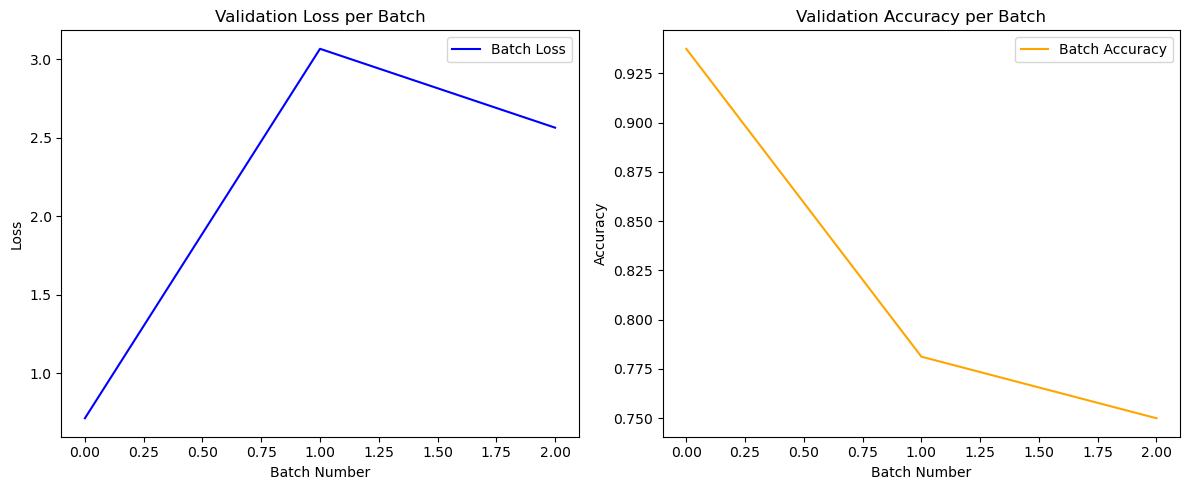

In [56]:
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Batch Loss', color='blue')
plt.title('Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Batch Accuracy', color='orange')
plt.title('Validation Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Validation set: Average loss: 0.000014, Accuracy: 320/80 (400%)

prediction  tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0])
target  tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0])


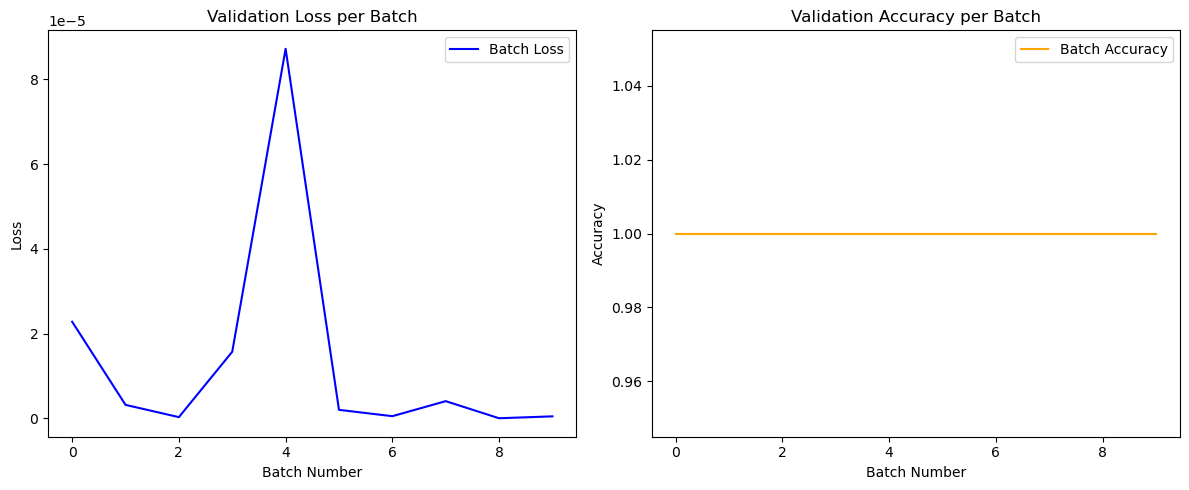

In [61]:
dataset = datasets.ImageFolder(root='testing', transform=transform)
dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model.load_state_dict(torch.load('CNN_model.pth')) 
model.eval()
test_loss = 0
loss_list = []
correct = 0
accuracy_list = []
with torch.no_grad():
        batch_count = 0
        for batch_idx, (data, target) in enumerate(dataset_loader):
                batch_count += 1 
                # Use the CPU or GPU as appropriate
                data, target = data.to(device), target.to(device)
                # Get the predicted classes for this batch
                output = model(data)
                # Calculate the loss for this batch
                loss = loss_criteria(output, target)
                test_loss += loss.item()
                loss_list.append(loss.item())
                # Calculate the accuracy for this batch
                _, predicted = torch.max(output.data, 1)
                correct += torch.sum(target==predicted).item()
                accuracy = torch.sum(target == predicted).item() / target.size(0)
                accuracy_list.append(accuracy)
avg_loss = test_loss/batch_count
print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
avg_loss, correct, len(val_loader.dataset), 100. * correct / len(val_loader.dataset)))
print('prediction ', predicted)
print('target ', target)
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Batch Loss', color='blue')
plt.title('Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Batch Accuracy', color='orange')
plt.title('Validation Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()     
            